### Imports

In [48]:
from matplotlib import pyplot as plt
import xml.etree.ElementTree as et
import numpy as np
import glob

### File selection

In [49]:
#this just allows easy folder selection so you don't have to copy the name from the file browser

folders = glob.glob("maps/*_map")
for i in range(0, len(folders)):
    print(str(i) + "\t" + str(folders[i]))

0	maps\20230531_CVD_3076_map
1	maps\20230531_CVD_3158_map
2	maps\20230606_CVD_2555_map
3	maps\20230607_CVD_2546_map
4	maps\20230607_CVD_2802_map
5	maps\20230613_CVD_2808_map
6	maps\20230613_CVD_3496_map
7	maps\20230621_CVD_2566_map
8	maps\20230621_CVD_2808_map
9	maps\20230623_CVD_2566_map
10	maps\20230626_CVD_2808_map
11	maps\20230627_CVD_2546_map
12	maps\20230628_CVD_2546_map
13	maps\20230711_CVD_2546_map
14	maps\20230721_CVD_3158_map


In [50]:
path_label = folders[3][5:-4]

sample_name = "CVD" + path_label[-4:]

if len(glob.glob("maps/"+path_label+"_map/*.spx")) == 200:
    grid_size = 10
elif len(glob.glob("maps/"+path_label+"_map/*.spx")) == 800:
    grid_size = 20
else:
    raise FileNotFoundError("Folder contains neither 200 nor 800 .spx files.")

#edit this to change which grid point is read
spec = [1, 5]

fp1 = ("maps/" + path_label + "_map/" + path_label + "_60s_" +
       str(grid_size) + "x" + str(grid_size) + "ptsdet_1_" + str(spec[0]) + "_" + str(spec[1]) + ".spx")

fp2 = ("maps/" + path_label + "_map/" + path_label + "_60s_" +
       str(grid_size) + "x" + str(grid_size) + "ptsdet_2_" + str(spec[0]) + "_" + str(spec[1]) + ".spx")

### Function definitions

In [51]:
def getIntensity(r, z):
    """z can be an int or string representing atomic number of element. (not a float)
    returns net intensity of element z"""
    result = r.findall("./ClassInstance[@Type='TRTSpectrum']/ClassInstance[@Type='TRTResult']/RoiResults/Atom[.='"
                         + str(z)
                         + "']/..")
    if len(result) == 0:
        raise Exception("Could not find intensity of element " + str(z))
    else:
        print(result[0].findall("./Description")[0].text, "Peak")
        return int(result[0].findall("./NetCounts")[0].text)

In [52]:
def getEnergyAxis(r):
    num_channels = int(r.findall("./ClassInstance[@Type='TRTSpectrum']/ClassInstance[@Type='TRTSpectrumHeader']/"
                                 "ChannelCount")[0].text)
    chan_to_en_m = float(r.findall("./ClassInstance[@Type='TRTSpectrum']/ClassInstance[@Type='TRTSpectrumHeader']/"
                                 "CalibLin")[0].text)
    chan_to_en_b = float(r.findall("./ClassInstance[@Type='TRTSpectrum']/ClassInstance[@Type='TRTSpectrumHeader']/"
                                 "CalibAbs")[0].text)
    return np.arange(0, 4096)*chan_to_en_m + chan_to_en_b

In [53]:
def getRawCountsData(r):
    data = r.findall("./ClassInstance[@Type='TRTSpectrum']/Channels")[0].text.split(",")
    #for i in range(0, len(data)):
    #    data[i] = int(data[i])

    #numpy can convert str to int
    return np.array(data, dtype=int)

In [54]:
def getBackgroundData(r):
    background = r.findall("./ClassInstance[@Type='TRTSpectrum']/ChildClassInstances/ClassInstance"
          "[@Type='TRTXRFBulkQuantificationResults']/TRTSpectrumQuantificationResults/"
          "ClassInstance[@Type='TRTSpectrumList']/ChildClassInstances/ClassInstance"
          "[@Type='TRTSpectrum']/Channels")[0].text.split(",")
    #for i in range(0, len(background)):
    #    background[i] = float(background[i])

    #numpy can convert str to float
    return np.array(background, dtype=float)

### Data reading
modify this cell to change which data is read

In [55]:
dat = {
    "d1_counts": getRawCountsData(et.parse(fp1).getroot()),
    "energy": getEnergyAxis(et.parse(fp1).getroot())}

### Plotting
modify this cell to change how the data is plotted

In [56]:
ms = 20 #marker size
title_font = {"fontsize": 36}
legend_font_size = 20
axes_font = {"fontsize": 30}
tick_label_size = 20
fit_line_size = 2
grid_width = 0.4

figure_size = (6, 5)

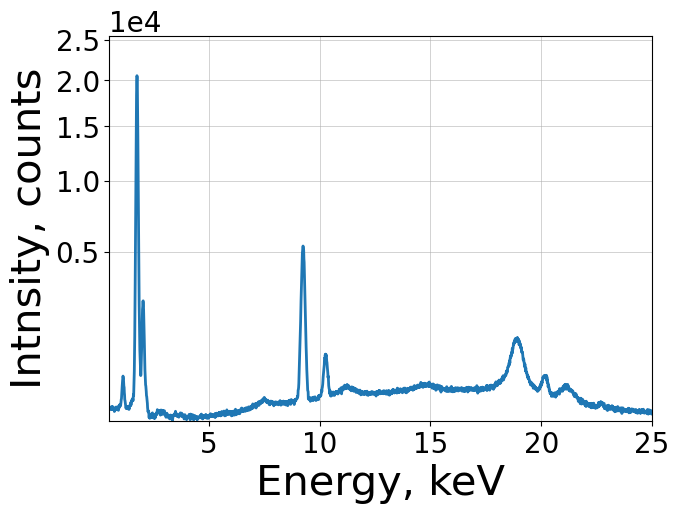

In [57]:
upper_ylim = np.max(dat["d1_counts"][150:]) + 5000

f, ax = plt.subplots(figsize=(7,5))
ax.plot(dat["energy"], dat["d1_counts"], label = "detector 1", linewidth=fit_line_size)
#ax.plot(dat["energy"], dat["d2_counts"], label = "detector 2")

#square root scale
ax.set_yscale("function", functions=(np.sqrt, lambda x: x*x))

#log scale
#ax.set_yscale("log")

ax.grid(visible=True, linewidth=grid_width)
ax.set_ylabel("Intnsity, counts", fontdict=axes_font)
ax.set_xlabel("Energy, keV", fontdict=axes_font)
#ax.set_title("Ellipsometry vs. XRR thickness", fontdict=title_font)
#ax.legend(fontsize=legend_font_size)
ax.tick_params(axis="both", which="major", labelsize=tick_label_size)
#ax.tick_params(axis="y", rotation=45)
ax.ticklabel_format(axis="y", scilimits=(0,3))
ax.yaxis.get_offset_text().set_fontsize(tick_label_size)

ax.axis([0.5, 25, 1, upper_ylim])
ax.grid(True)
plt.show()